# Notebook 8: Binary Classifier Exercise [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mattsankner/micrograd/blob/main/mg8_binary_classifer.ipynb) [![View in nbviewer](https://img.shields.io/badge/view-nbviewer-orange)](https://nbviewer.jupyter.org/github/mattsankner/micrograd/blob/main/mg8_binary_classifier.ipynb)

## Let's build a binary classifier with our micrograd engine! This will be able to tell whether random points on a graph are red or blue.

Below, I take Andrej's example and expound on it with my notes about the code. You won't understand all of it just from the series of lectures, but it runs on what we already went through, although the code is slightly different, you should be able to understand what is going on, especially if you test with different outputs along the way.

In [2]:
# This code is adapted from [Andrei Karpathy]
# Copyright (c) [2020] [Andrei Karpathy]

import random
import numpy as np
import matplotlib.pyplot as plot
%matplotlib inline

In [3]:
#import the micrograd we made
from micrograd.engine import Value 
from micrograd.mlp import Neuron, Layer, MLP

In [20]:
#set random seeds for reproducibility. Numpy and random both have seeds set.
#every time the code is run, it will generate the same random numbers, 
#which means that the dataset and any other random operations produce the same results
np.random.seed(1337)
random.seed(1337)

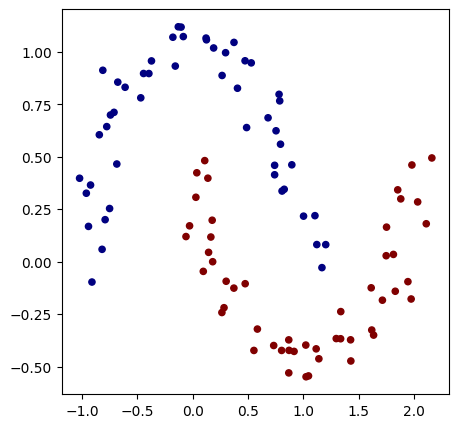

In [21]:
from sklearn.datasets import make_moons, make_blobs

# create dataset using 'make_moons' from sklearn
# generates synthetic dataset with two interleaving half circles shape
X, y = make_moons(n_samples=100, noise=0.1) #adds gaussian noise to the data

# make y axis to be -1 to 1 instead of 0 to 1 (default)
y = y * 2 - 1 

# print dataset in 2D
plot.figure(figsize=(5,5)) #figure width/height in inches

# creates scatter plot of data with x and y coordinates. c=y sets color based on labels; s is size of the points, cmap=jet is colormap
plot.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

### ReLU

Below, we initialize the neural network, which will be made with the micrograd I created in this repository. It is made with a ```ReLU``` function instead of a ```tanh()``` activation function, as Andrei coded his this way in his final product. 

Recall from the notebooks that without an activation functions to introduce non-linearity into the network, the network would not be able to learn complex patterns and functions; it would simply be equivalent to a single-layer lienar model, which would limit its modeling power. Activation functions enable stacking of multiple layers, where each layer learns different levels of abstraction. Different activation functions can control the range of the output values. 

After some research, here is the theory behind why we implemented ```ReLU()``` in micrograd and are using it here:

### ```tanh(): Hyperbolic Tangent```

$$tanh(x)={\frac {\sinh x}{\cosh x}}={\frac {e^{x}-e^{-x}}{e^{x}+e^{-x}}}={\frac {e^{2x}-1}{e^{2x}+1}}$$

### ```ReLU(): Rectified Linear Unit```

$$ReLU(x)={max(0, x)}$$

- While ```tanh()``` outputs between -1 and 1, ```ReLU``` outputs $0$ for any negative input and the input itself for any positive input

- In the backward pass, ```tanh()```'s derivativce is $1-tanh(x)^2$, which can lead to small gradients for large values of $x$, potentially causing ```vanishing gradients```. The ```ReLU```'s derivative is $1$ for positive outputs and $0$ for negative inputs, making gradient calculation straightforward.

- ```vanishing gradients```: when the gradients of the loss function with respect to the model parameters become very small, effectively approaching zero. This can severely slow down or even stop the training process becasue the updates to the model parameters become insignificant.
  
- For ```tanh()```, when the input values are are very large or very small, ```tanh(x)``` saturates to $-1$ or $1$, making the gradient close to $0$. Since these gradients get mutliplied through each layer, it results in exponentially smaller gradients continually, which makes it tough for the model to learn.

- For ```ReLU()```, it doesn't squash the gradients into a small range, so it doesn't have this problem. It suffers from a different problem, however, known as the ```dying ReLU``` porblem, where neurons get stuck with a gradient of $0$ if they always output $0$.

- Note: another common activation function is ```sigmoid(x)```, which outputs values between $0$ and $1$, and is useful for binary classification, although they can also suffer from the vanishing gradient problem. Its function is 
$${\frac {1}{1 + {e^{-x}}}}$$

In [22]:
model = MLP(2, [16, 16, 1]) # 2-layer neural network: 2 inputs, 2 hidden layers with 16 

print("parameter count: ", len(model.parameters()))

parameter count:  337


## Observe the loss function below. Use comments and explanations below the code block to aod your understanding.

In [25]:
# loss function
def loss(batch_size=None): #compare predictions to labels. Xb = data; yb = labels
    
    #batch selection
    if batch_size is None:
        Xb, yb = X, y # Use the entire dataset
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size] # randomly select a batch of batch_size, if specified
        Xb, yb = X[ri], y[ri] #randomly select a subset of the data
        
    inputs = [list(map(Value, xrow)) for xrow in Xb] # Convert input rows to Value objects for automatic differentiation
    
    #passing the inputs through the model to compute the scores (predictions)
    #map function applies a given function (model; an mlp instance) to each item of an iterable(inputs; list of input vectors) and returns an iterator (object)
    scores = list(map(model, inputs))
    
    # calculates "max-margin" loss for each prediction and applies ReLU(). 
    #for each y and score for the given x input to mlp, calculate loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses)) #dataloss = average of these individual losses
    
    #adds an L2 regularization (weight decay) term to the loss to prevent overfitting
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters())) #regularization term: alpha * sum of p^2 for all params p in model
    total_loss = data_loss + reg_loss #total loss = sum of data loss and regularization loss
    
    #calculate accuracy... measures proportion of correct predictions, determines if predictions are correct
    #checks if sign of true label yi and predictions scorei are both positive -> then the prediction is correct
    #results in a list of boolean values for correct and incorrect predictions inside accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)] 

    #sum(accuracy) = number of true values in accuracy list (num of correct predictions)
    #len(accuracy) = total number of predictions
    #sum/len = accuracy as a fraction of correct predictions
    return total_loss, sum(accuracy) / len(accuracy) #return loss and accuracy

total_loss, acc = loss() #compute total loss and accuracy for current model state
print("Total loss: ", total_loss.data, ", Accuracy: ", acc*100, "%")

Total loss:  0.8958441028683222 , Accuracy:  50.0 %


As you can see, the initial loss is high accuracy is low.

## Explanation:
This is the code that gives us the losses using ```ReLU``` for each pair of ```yi``` and ```scorei```:
``` python
losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
```
You could write its main function as:
```python
loss = ReLU(1 + -y[i] * score[i]
```

### ReLU():
```ReLU(x) = max(0,x)```
- it outputs x if x is positive, and 0 if x is negative. This non-linearity allows the net to learn complex functions.


### Hinge Loss:
The hinge loss function is commonly used for ```max-margin``` classification, such as in support vector machines(svm's). The hinge loss for a single prediction is defined as:

```loss = max(0,1 - y[i] * score[i]```

Here, ```y[i]``` is the true label, either $1$ or $-1$, and ```score[i]``` is the predicted score. The hinge loss penalizes the predictions if it does not exceed the margin (set to $1$ here) in the correct direction. 

### Margin-Based Loss:
In the code, the ```ReLU``` function is used as a part of caluclating the hinge loss to get the ```margin-based loss```. The ```ReLU``` is taking the ```max()``` of $0$ and ```1 - y[i] * score[i]```. 

This ensures that the hinge loss will be $0$ or $>0$, because it's taking the ```max()``` of $0$ and the ```hinge loss value```. 

The hinge loss penalizes predictions that are correct but not confident enough (within the margin) or incorrect. If the product of ```y[i] * score[i] < 1```, the prediction is either incorrect or not within a safe margin. For ```y[i]>0```, the score should be greater than $1$, 
and for ```y[i]<0```, the score should be less than $-1$. 

### True Labels ($y[i]$)):

For binary classification, the true labels are typically either $+1$ or $-1$. In this example, $( yb[0] = 1 ) and ( yb[1] = -1 )$.

### Predicted Scores ($score[i]$)):

These are the outputs of the model. In the example, we have $score[0] = 0.8$ and $score[1] = -0.6$.

Adding $1$ to this product shifts the hinge loss so that it is zero or positive:

- For correctly classified examples with a sufficient margin,$1- -y[i] * score[i]$ will be less than $0$, and ReLU will make it $0$.
- For incorrectly classified examples or those within the margin, $1 - -y[i] * score[i]$ will be positive, and ReLU will keep the positive value.


### Examples:

Prediction is correct but not confident enough (within margin), resulting in small loss.
- ```y[i] = 1; score[i] = 0.8``` -> $1 - y[i] * score[i] = 1 - 1 * 0.8 = 0.2$   -> ```ReLU(0.2) = 0.2)```
  
Prediction is incorrect, resulting in a significant loss:
- ```y[i] = 1; score[i] = -0.5``` -> $1 - y[i] * score[i] = 1 - 1 * (-0.5) = 1 + 0.5 = 1.5$   ->   ```ReLU(1.5) = 1.5```

Prediction is incorrect:
- ```y[i] = -1; score[i] = 0.3```  -> $1 - y[i] * score[i] = 1- (-1) * 0.3 = 1 + 0.3 = 1.3$    -> ```ReLU(1.3) = 1.3```

Prediction is correct but not condient enough:
- ```y[i] = -1; score[i] = 0.7```   -> $1 -y[i] * score[i] = 1 - (-1) * (-0.7) = 1 - 0.7 = 0.3$   ->   ```ReLU(0.3) = 0.3```

### L2 Regularization:

```python
alpha = 1e-4 #a hyperparameter; the regularization strength set to a small value
reg_loss = alpha * sum((p*p for p in model.parameters())) #scales the sum of squared parameters by the regularization strength
total_loss = data_loss + reg_loss 
#total loss = sum of data loss(loss computed from predictions and true labels using hinge loss and relu) 
#reg_loss = regularization loss (l2)
```

Penalizes large weights in the model to prevent overfitting. This encourages the model to keep the weigths smaller, which often leads to better generalization. 

Combining the two losses ```data_loss``` and ```reg_loss``` gives the total loss used for backpropogation. This ensures that the optimization process considers both the fit to the data and complexity of the model through regularization.

In [8]:
# optimization
for k in range(100):
    
    # forward, compute total loss and accuracy
    total_loss, acc = loss()
    
    # backward
    model.zero_grad() #reset grads
    total_loss.backward() 
    
    # update params of model (sgd)
    learning_rate = 1.0 - 0.9*k/100 #learning rate goes from 1.0 - .9 *0/100 -> 1.0 - .9 * 99/100 = 1.0 -> .109
    for p in model.parameters():
        p.data -= learning_rate * p.grad #updates data of each p by subtracting product of learning rate and gradient
        #moves p in direction of reduced loss
    
    if k % 1 == 0:
        print(f"step {k + 1} loss {total_loss.data}, accuracy {acc*100}%")

step 1 loss 0.8958441028683222, accuracy 50.0%
step 2 loss 1.723590533697202, accuracy 81.0%
step 3 loss 0.7429006313851131, accuracy 77.0%
step 4 loss 0.7705641260584201, accuracy 82.0%
step 5 loss 0.3692793385976537, accuracy 84.0%
step 6 loss 0.313545481918522, accuracy 86.0%
step 7 loss 0.28142343497724337, accuracy 89.0%
step 8 loss 0.26888733313983904, accuracy 91.0%
step 9 loss 0.2567147286057417, accuracy 91.0%
step 10 loss 0.27048625516379227, accuracy 91.0%
step 11 loss 0.24507023853658041, accuracy 91.0%
step 12 loss 0.25099055297915024, accuracy 92.0%
step 13 loss 0.21560951851922952, accuracy 91.0%
step 14 loss 0.2309037844640272, accuracy 93.0%
step 15 loss 0.20152151227899456, accuracy 92.0%
step 16 loss 0.2257450627928221, accuracy 93.0%
step 17 loss 0.19447987596204114, accuracy 92.0%
step 18 loss 0.21089496199246363, accuracy 93.0%
step 19 loss 0.15983077356303607, accuracy 94.0%
step 20 loss 0.1845374874688391, accuracy 93.0%
step 21 loss 0.18977522856087642, accurac

The model improves significantly, achieving $100%$ ```accuracy``` with very low ```loss.```

### Below we visualize the decision boundary of the trained model. 

It creates a grid of points over the input space, predicts the class for each point using the model, and then plots the decision boundary along with the original data points. 

The ```h``` parameter controls the resolution of the grid, and the use of ```X[:, 0]``` and ```X[:, 1]``` extracts the ```x``` and ```y``` coordinates of the data points. The mesh grid creation and prediction steps ensure that the decision boundary is accurately plotted based on the model's predictions.

(-1.548639298268643, 1.951360701731357)

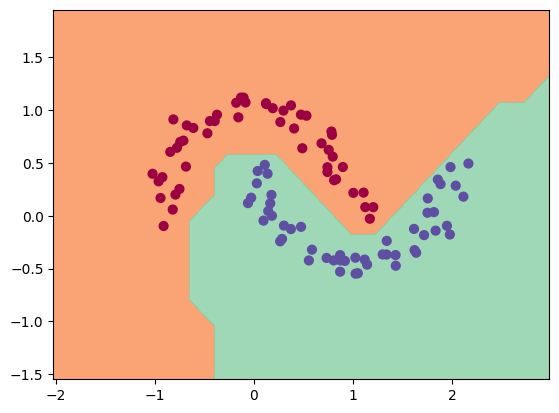

In [13]:
# visualize decision boundary

h = 0.25 #step size for mesh grid. Defines resolution of grid for plotting decision boundary. Smaller vals = finer grid

#x_min, x_max; y_min, y_max are the minimum and maximum values of the x and y-coordinates of the data points, 
#extended by 1 unit on each side for better visualization.
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

#np.arrange() generates  values from x_min to x_max and y_min to y_max with a step size of h.
#np.meshgrid takes these ranges and creates two 2D arrays xx and yy representing the grid coordinates. 
#xx contains the x-coordinates and yy contains the y-coordinates of the grid point
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

#xx.ravel() and yy.ravel() flatten the 2D arrays xx and yy into 1D arrays
#np.c_[...] combines these 1D arrays column-wise to form a 2D array Xmesh where each row is a point on the grid.
Xmesh = np.c_[xx.ravel(), yy.ravel()]

#each row of Xmesh is converted into a list of Value objects (used for automatic differentiation by the micrograd library)
#this step is necessary for the model to process the inputs and make predictions
inputs = [list(map(Value, xrow)) for xrow in Xmesh]

#map(model, inputs) applies the model to each point in inputs, producing a list of scores (predictions)
scores = list(map(model, inputs))

#s.data > 0 checks if the score is positive, indicating that the model predicts the positive class for that point
#np.array([...]) converts the list of boolean values into a NumPy array.
Z = np.array([s.data > 0 for s in scores])

#reshapes this 1D array back into the 2D shape of the grid, matching xx and yy.
Z = Z.reshape(xx.shape)

fig = plot.figure() #new figure for plotting
plot.contourf(xx, yy, Z, cmap=plot.cm.Spectral, alpha=0.8) #plot decision boundary
plot.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plot.cm.Spectral) #plot original data points
plot.xlim(xx.min(), xx.max()) #sets the limits of the x-axis to the range of the grid
plot.ylim(yy.min(), yy.max()) #sets the limits of the y-axis to the range of the grid

### Above, our neural network has  learned to separate the two classes well, as indicated by the clear boundary between the orange and green regions. The red and blue points correspond to the two classes, and they are on the correct side of the boundary.

# Summary:

- The model starts with an initial ```accuracy = 50%``` and ```loss = 0.896```.
- Through 100 iterations of training with Stochastic Gradient Descent, the model improves significantly, achieving final ```accuracy = 100%``` and a very low ```loss=0.011```.
- The decision boundary visualization confirms that the model has learned to separate the two classes effectively
- This process demonstrates the effectiveness of the neural netwrok in learning a non-linear decision boundary to classify the ```make_moons``` dataset accurately.